In [38]:
import numpy as np
import matplotlib.pyplot as plt
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from astropy import units as u
import scipy.signal
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.fftpack import ifft, ifftshift

temp = {
  "O5": "uko5v.dat",
  "O9": "uko9v.dat",
  "A0": "uka0v.dat",
  "A2": "uka2v.dat",
  "A3": "uka3v.dat",
  "A5": "uka5v.dat",
  "A7": "uka7v.dat",
  "B0": "ukb0v.dat",
  "B1": "ukb1v.dat",
  "B3": "ukb3v.dat",
  "B8": "ukb8v.dat",
  "B9": "ukb9v.dat",
  "F0": "ukf0v.dat",
  "F2": "ukf2v.dat",
  "F5": "ukf5v.dat",
  "F6": "ukf6v.dat",
  "F8": "ukf8v.dat",
  "G0": "ukg0v.dat",    
  "G2": "ukg2v.dat",
  "G5": "ukg5v.dat",
  "G8": "ukg8v.dat",
  "K0": "ukk0v.dat",
  "K2": "ukk2v.dat",
  "K3": "ukk3v.dat",
  "K4": "ukk4v.dat",
  "K5": "ukk5v.dat",
  "K7": "ukk7v.dat",
  "M1": "ukm1v.dat",
  "M2": "ukm2v.dat",
  "M3": "ukm3v.dat",
  "M4": "ukm4v.dat",
  "M5": "ukm5v.dat",
  "M6": "ukm6v.dat",
  "rF6": "ukrf6v.dat",
  "rF8": "ukrf8v.dat",
  "rG0": "ukrg0v.dat",
  "rG5": "ukrg5v.dat",
  "wF5": "ukwf5v.dat",
  "wF8": "ukwf8v.dat",
  "wG0": "uka3v.dat",
  "wG5": "uka3v.dat",
}
asci = {
  "PCygni": "ascii2",
  "51Aql": "ascii3",
  "Albali": "ascii4",
  "HD214923": "ascii5",
  "HD215648": "ascii6",
  "10 Lac": "ascii7",
  "HD212698": "ascii10",
  "HIP20900": "ascii11",
  "HIP114046": "ascii12",
}
const1 = 4.965114232
################### Fungsi ##############################################
def normal(x,A =1, mu=0, sigma=1, asli=False):
    if asli:
        y = 1/np.sqrt(2*np.pi)/sigma*np.exp(-(x-mu)**2/2/sigma**2)
    else:
        y = A*np.exp(-(x-mu)**2/2/sigma**2)
    return y

def lorentz(x, A, mu=0, sigma=1):
    y = A/((x-mu)**2+0.25*sigma**2)
    return y

def planck(x, A=1, xmax=1):
    E = const1*xmax
    B = A*xmax**5*(np.exp(const1)-1)
    return B/x**5*1/(np.exp(E/x)-1)

def boxy(lebar, persen=0.9):
    N = len(lebar)
    box = np.zeros(N)
    nb1 = int((1-persen)*N)
    nb2 = int(persen*N)
    box[nb1+1:nb2] = 1 
    win = sgn.hann(N//10)
    filtered = sgn.convolve(box, win, mode='same') / sum(win)
    return filtered

def hnormal(arr, sigma=1):
    W = arr[-1]-arr[0]
    N = len(arr)
    x = np.linspace(0,W,N)
    y = np.exp(-x**2/2/sigma**2)
    return y

Template =  dict_keys(['O5', 'O9', 'A0', 'A2', 'A3', 'A5', 'A7', 'B0', 'B1', 'B3', 'B8', 'B9', 'F0', 'F2', 'F5', 'F6', 'F8', 'G0', 'G2', 'G5', 'G8', 'K0', 'K2', 'K3', 'K4', 'K5', 'K7', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'rF6', 'rF8', 'rG0', 'rG5', 'wF5', 'wF8', 'wG0', 'wG5'])
Objek =  dict_keys(['PCygni', '51Aql', 'Albali', 'HD214923', 'HD215648', '10 Lac', 'HD212698', 'HIP20900', 'HIP114046'])
Template = A0
Objek = PCygni


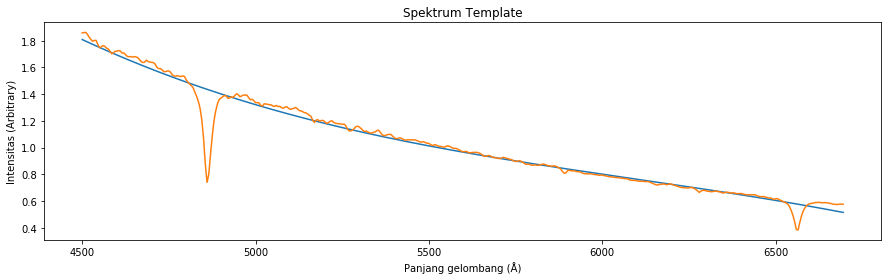

440


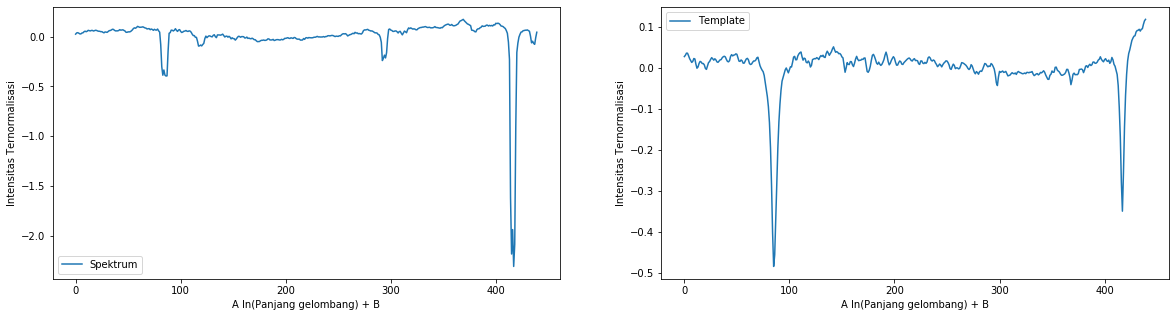

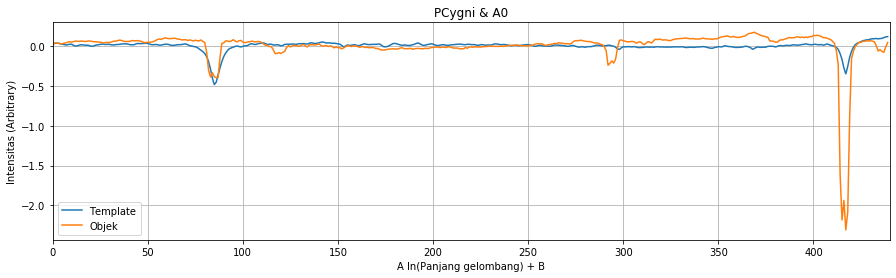

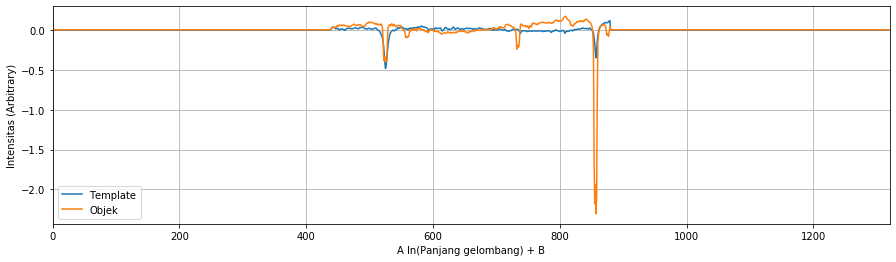

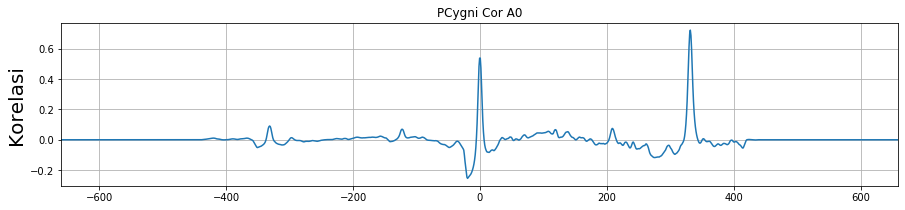

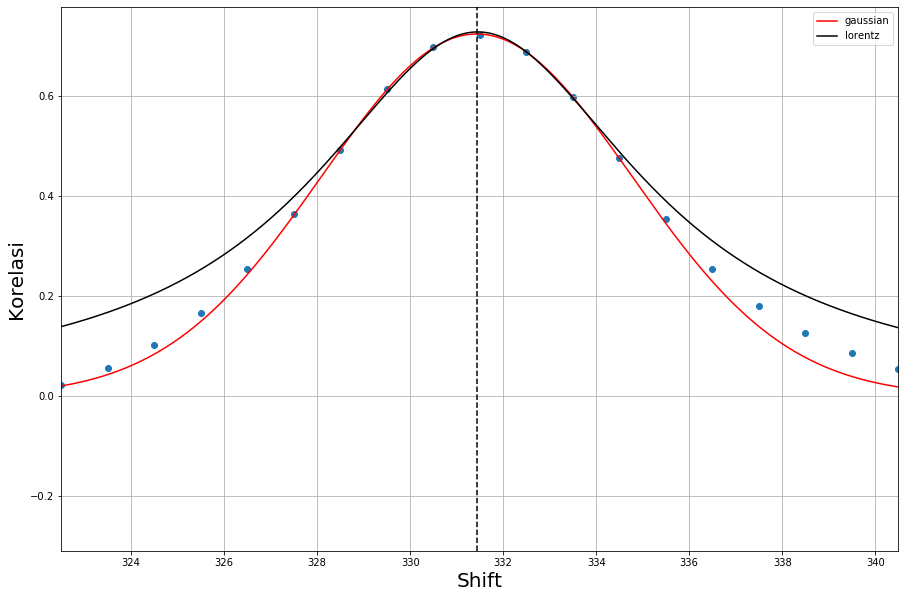

6.0
Korelasi =  0.7221556262699564
x = 331.432 
V = 104859.6 km/s
sigma = 3.34 
x2 = 331.451 
V2 = 104866.658 km/s
sigma2 = 8.696 
A =  1105.0041317705802
B =  -9295.10986247582


In [44]:
print('Template = ',temp.keys())
print('Objek = ',asci.keys())

################# Pengambilan data ##############
T = input('Template = ')
O = input('Objek = ')
template = temp[T]
spektrum = asci[O]

xt = np.loadtxt(template, usecols=0)
yt = np.loadtxt(template, usecols=1)

xs = np.loadtxt(spektrum, usecols=0)
ys = np.loadtxt(spektrum, usecols=1)

mins = 4500
maxs = 6700
fs = interp1d(xs, ys, kind='cubic')
############## pre-proc ####################
x = []
y = []

jalan = 0
while(xt[jalan] < mins):
    jalan += 1
while (xt[jalan] < maxs):
    x.append(xt[jalan])
    y.append(yt[jalan])
    jalan += 1

xt = x
yt = y
    
x = []
y = []

jalan = 0
while(xs[jalan] < mins):
    jalan += 1
while (xs[jalan] < maxs):
    x.append(xs[jalan])
    y.append(ys[jalan])
    jalan += 1
xs = x
ys = y
########### Membuat kontinum template #############
spectrum = Spectrum1D(flux=yt*u.Jy, spectral_axis=xt*u.um)
g1_fit = fit_generic_continuum(spectrum)
yc = g1_fit(xt*u.um)

plt.figure(figsize=(15,4))
plt.plot(xt,yc)
plt.plot(xt,yt)
plt.xlabel('Panjang gelombang (Å)')
plt.ylabel('Intensitas (Arbitrary)')
plt.title('Spektrum Template')
plt.show()

yt = yt/yc
xs = xt
ys = fs(xt)

ys = ys -np.mean(ys)
yt = yt -np.mean(yt)
############### Spektrum geser
fs = interp1d(xs, ys, kind='cubic')
ft = interp1d(xt, yt, kind='cubic')

c = 299_792.458
BIN = len(xs)

A = (BIN-1)/np.log(xs[-1]/xs[0])
B = -A*np.log(xs[0])
print(BIN)
xbins = np.arange(BIN)
xbint = np.arange(BIN)

xsinterp = np.round(xs[0]*np.exp(xbins/A),4)
ybins = fs(xsinterp)

xtinterp = np.round(xs[0]*np.exp(xbint/A),4)  
ybint = ft(xtinterp)

########### Plot #######################
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(xbins,ybins,label='Spektrum')
ax1.legend(loc='best')
ax1.set_xlabel('A ln(Panjang gelombang) + B')
ax1.set_ylabel('Intensitas Ternormalisasi')
ax2.plot(xbint,ybint,label='Template')
ax2.legend(loc='best')
ax2.set_xlabel('A ln(Panjang gelombang) + B')
ax2.set_ylabel('Intensitas Ternormalisasi')
plt.show()

plt.figure(figsize=(15,4))
plt.title(O+' & '+T)
plt.plot(xbint,ybint, label='Template')
plt.plot(xbins,ybins,label='Objek')
plt.legend(loc='best')
plt.xlabel('A ln(Panjang gelombang) + B')
plt.ylabel('Intensitas (Arbitrary)')
plt.grid(axis='both')
plt.xlim(0,BIN)
plt.show()

####### Preperation ##########
meant = np.mean(ybint)
means = np.mean(ybins)

xx = np.arange(3*len(xbins))
YS = np.ones(len(xx))*means
YT = np.ones(len(xx))*meant

YS[len(xbins):2*len(xbins)] = ybins
YT[len(xbins):2*len(xbins)] = ybint

plt.figure(figsize=(15,4))
plt.plot(xx,YT, label='Template')
plt.plot(xx,YS,label='Objek')
plt.legend(loc='best')
plt.xlabel('A ln(Panjang gelombang) + B')
plt.ylabel('Intensitas (Arbitrary)')
plt.grid(axis='both')
plt.xlim(0,3*BIN)
plt.show()
cor = np.zeros(3*len(xbins))
for i in xx:
    cor[i] = np.sum(YS[xx]*YT[xx-i])
cor = fftshift(cor)/(len(xx)*np.std(YS)*np.std(YT))    

xbaru = xx - np.median(xx)
vnya = c*(np.exp(xbaru/A)-1)
peak = xbaru[np.argmax(cor)]

plt.figure(figsize=(15,3))
plt.plot(xbaru, np.real(cor))
plt.title(O+' Cor '+T)
plt.xlim(xbaru[0],xbaru[-1])
plt.ylabel('Korelasi',fontsize=20)
plt.grid()
plt.show()

xtengah = np.argmax(cor)
for i in range(len(xx)//2):
    if cor[xtengah-i] < max(cor)*0.8:
        xbawah = xtengah-i
        xatas = xtengah+i
        TheI = i
        break

popt, pcov = curve_fit(lorentz, xbaru[xbawah:xatas], cor[xbawah:xatas],p0=(1,0,xbaru[xatas]-xbaru[xbawah]))

xfit = np.linspace(xbaru[xbawah-2*TheI],xbaru[xatas+2*TheI], 1000)
popt, pcov = curve_fit(normal, xbaru[xbawah:xatas], cor[xbawah:xatas],p0=(1,xbaru[xtengah],xbaru[xatas]-xbaru[xbawah]))
corfit = normal(xfit, A=popt[0], mu=popt[1], sigma=popt[2])
popt2, pcov2 = curve_fit(lorentz, xbaru[xbawah:xatas], cor[xbawah:xatas],p0=(1,xbaru[xtengah],xbaru[xatas]-xbaru[xbawah]))
corfit2 = lorentz(xfit, A=popt2[0], mu=popt2[1], sigma=popt2[2])
plt.figure(figsize=(15,10))
plt.scatter(xbaru, np.real(cor))
plt.plot(xfit,corfit,'r',label='gaussian')
plt.plot(xfit,corfit2,'k',label='lorentz')
plt.xlim(xbaru[xbawah-2*TheI],xbaru[xatas+2*TheI])
plt.axvline(x=popt[1],c = 'k',ls='--')
plt.xlabel('Shift',fontsize=20)
plt.ylabel('Korelasi',fontsize=20)
plt.legend(loc='best')
plt.grid()
plt.show()

print(xbaru[xatas]-xbaru[xbawah])
print('Korelasi = ',max(cor))
print('x = %s '%str(round(popt[1],3)))
print('V = %s km/s'%str(round(c*(np.exp(popt[1]/A)-1),3)))
print('sigma = %s '%str(round(abs(popt[2]),3)))

print('x2 = %s '%str(round(popt2[1],3)))
print('V2 = %s km/s'%str(round(c*(np.exp(popt2[1]/A)-1),3)))
print('sigma2 = %s '%str(round(abs(popt2[2]),3)))
print('A = ',A)
print('B = ',B)

In [14]:
tulis = open('Hasil.txt','w')
tulis.write('Nama'+' '+'KorelasiG'+' '+'Vg'+' '+"sg"+' '+'korelasiL'+' '+'Vl'+' '+'sl'+'\n')
for SPEK in asci:
    spektrum = asci[SPEK]
    tulis.write(str(SPEK)+'\n')
    for TEMP in temp:
################# Pengambilan data ##############
        template = temp[TEMP]
    
        xt = np.loadtxt(template, usecols=0)
        yt = np.loadtxt(template, usecols=1)

        xs = np.loadtxt(spektrum, usecols=0)
        ys = np.loadtxt(spektrum, usecols=1)

        mins = 4500
        maxs = 6700
        fs = interp1d(xs, ys, kind='cubic')
        ############## pre-proc ####################
        x = []
        y = []

        jalan = 0
        while(xt[jalan] < mins):
            jalan += 1
        while (xt[jalan] < maxs):
            x.append(xt[jalan])
            y.append(yt[jalan])
            jalan += 1

        xt = x
        yt = y

        x = []
        y = []

        jalan = 0
        while(xs[jalan] < mins):
            jalan += 1
        while (xs[jalan] < maxs):
            x.append(xs[jalan])
            y.append(ys[jalan])
            jalan += 1
        xs = x
        ys = y
        ########### Membuat kontinum template #############
        spectrum = Spectrum1D(flux=yt*u.Jy, spectral_axis=xt*u.um)
        g1_fit = fit_generic_continuum(spectrum)
        yc = g1_fit(xt*u.um)

        yt = yt/yc
        xs = xt
        ys = fs(xt)

        ys = ys -np.mean(ys)
        yt = yt -np.mean(yt)
        ############### Spektrum geser
        fs = interp1d(xs, ys, kind='cubic')
        ft = interp1d(xt, yt, kind='cubic')

        c = 299_792.458
        BIN = len(xs)

        A = (BIN-1)/np.log(xs[-1]/xs[0])
        B = -A*np.log(xs[0])

        xbins = np.arange(BIN)
        xbint = np.arange(BIN)

        xsinterp = np.round(xs[0]*np.exp(xbins/A),4)
        ybins = fs(xsinterp)

        xtinterp = np.round(xs[0]*np.exp(xbint/A),4)  
        ybint = ft(xtinterp)

        ####### Preperation ##########
        meant = np.mean(ybint)
        means = np.mean(ybins)

        xx = np.arange(3*len(xbins))
        YS = np.ones(len(xx))*means
        YT = np.ones(len(xx))*meant

        YS[len(xbins):2*len(xbins)] = ybins
        YT[len(xbins):2*len(xbins)] = ybint

        cor = np.zeros(3*len(xbins))
        for i in xx:
            cor[i] = np.sum(YS[xx]*YT[xx-i])
        cor = fftshift(cor)/(len(xx)*np.std(YS)*np.std(YT))    

        xbaru = xx - np.median(xx)
        vnya = c*(np.exp(xbaru/A)-1)
        peak = xbaru[np.argmax(cor)]

        xtengah = np.argmax(cor)
        for i in range(len(xx)//2):
            if cor[xtengah-i] < max(cor)*0.8:
                xbawah = xtengah-i
                xatas = xtengah+i
                TheI = i
                break

        popt, pcov = curve_fit(lorentz, xbaru[xbawah:xatas], cor[xbawah:xatas],p0=(1,0,xbaru[xatas]-xbaru[xbawah]))

        xfit = np.linspace(xbaru[xbawah-2*TheI],xbaru[xatas+2*TheI], 1000)
        popt, pcov = curve_fit(normal, xbaru[xbawah:xatas], cor[xbawah:xatas],p0=(1,xbaru[xtengah],xbaru[xatas]-xbaru[xbawah]))
        corfit = normal(xfit, A=popt[0], mu=popt[1], sigma=popt[2])
        popt2, pcov2 = curve_fit(lorentz, xbaru[xbawah:xatas], cor[xbawah:xatas],p0=(1,xbaru[xtengah],xbaru[xatas]-xbaru[xbawah]))
        corfit2 = lorentz(xfit, A=popt2[0], mu=popt2[1], sigma=popt2[2])
        Vg = round(c*(np.exp(popt[1]/A)-1),3)
        Vl = round(c*(np.exp(popt2[1]/A)-1),3)
        sigmag = round(c*(np.exp(abs(popt[2])/A)-1),3)
        sigmal = round(c*(np.exp(abs(popt2[2])/A)-1),3)
        tulis.write(str(TEMP)+' '+str(popt[0])+' '+str(Vg)+' '+str(sigmag)+' '+str(popt2[0]/(abs(popt2[2])/2)**2)+' '+str(Vl)+' '+str(sigmal)+'\n')
    print(SPEK)
print('udah')

51Aql
Albali
HD214923
HD215648
10 Lac
HD212698
HIP20900
HIP114046
udah


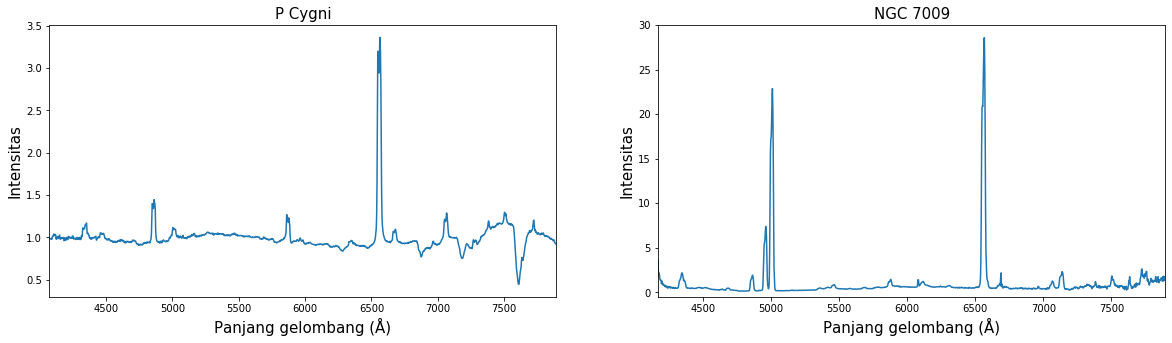

In [36]:
x1 = np.loadtxt('ascii2', usecols=0)
y1 = np.loadtxt('ascii2', usecols=1)
x2 = np.loadtxt('ascii8', usecols=0)
y2 = np.loadtxt('ascii8', usecols=1)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(x1,y1)
ax1.set_title('P Cygni',fontsize=15)
ax1.set_xlabel('Panjang gelombang (Å)',fontsize=15)
ax1.set_ylabel('Intensitas',fontsize=15)
ax1.set_xlim(x1[0],x1[-1])
ax2.plot(x2,y2)
ax2.set_title('NGC 7009',fontsize=15)
ax2.set_xlabel('Panjang gelombang (Å)',fontsize=15)
ax2.set_ylabel('Intensitas',fontsize=15)
ax2.set_xlim(x2[35],x2[-1])
ax2.set_ylim(-0.5,30)
plt.show()

In [16]:
plt.hist?